### Кластеризация клеток периферической крови от здорового донора после single-cell RNA sequencing

In [ ]:
# Установка необходимых библиотек
!pip3 install scanpy scrublet scikit-misc leidenalg 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.4/647.4 kB 45.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 73.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 4.0 MB/s eta 0:00:00
  Created wheel fo

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import scanpy.external as sce

In [ ]:
warnings.filterwarnings("ignore") # Отключаем warning'и, которые могут мешать по ходу работы
sc.settings.verbosity = 3 # Делаем так, чтобы scanpy выводил максимально подробные логи

# Настраиваем общую эстетику картинок
sc.settings.set_figure_params(dpi=100) # Качество картинок
sns.set(font_scale=1) # Размер шрифта
sns.set_style("ticks") # Стиль картинок

In [ ]:
adata_unfiltered = sc.read_10x_h5('/content/drive/MyDrive/outs/raw_feature_bc_matrix.h5') # Загружаем нефильтрованный датасет
print(adata_unfiltered)

reading /content/drive/MyDrive/outs/raw_feature_bc_matrix.h5
 (0:00:27)
AnnData object with n_obs × n_vars = 3069478 × 36601
    var: 'gene_ids', 'feature_types', 'genome'


In [ ]:
adata_unfiltered.obs.head() # Шапка датафрейма с аннотацией клеток, кроме баркодов пока ничего нет, но возможно добавление столбцов с указанием тканей или органов

In [ ]:
adata_unfiltered.var.head() # Шапка датафрейма с аннотацией генов

Text(0.5, 1.0, 'Распределение процента митохондриальной экспрессии')

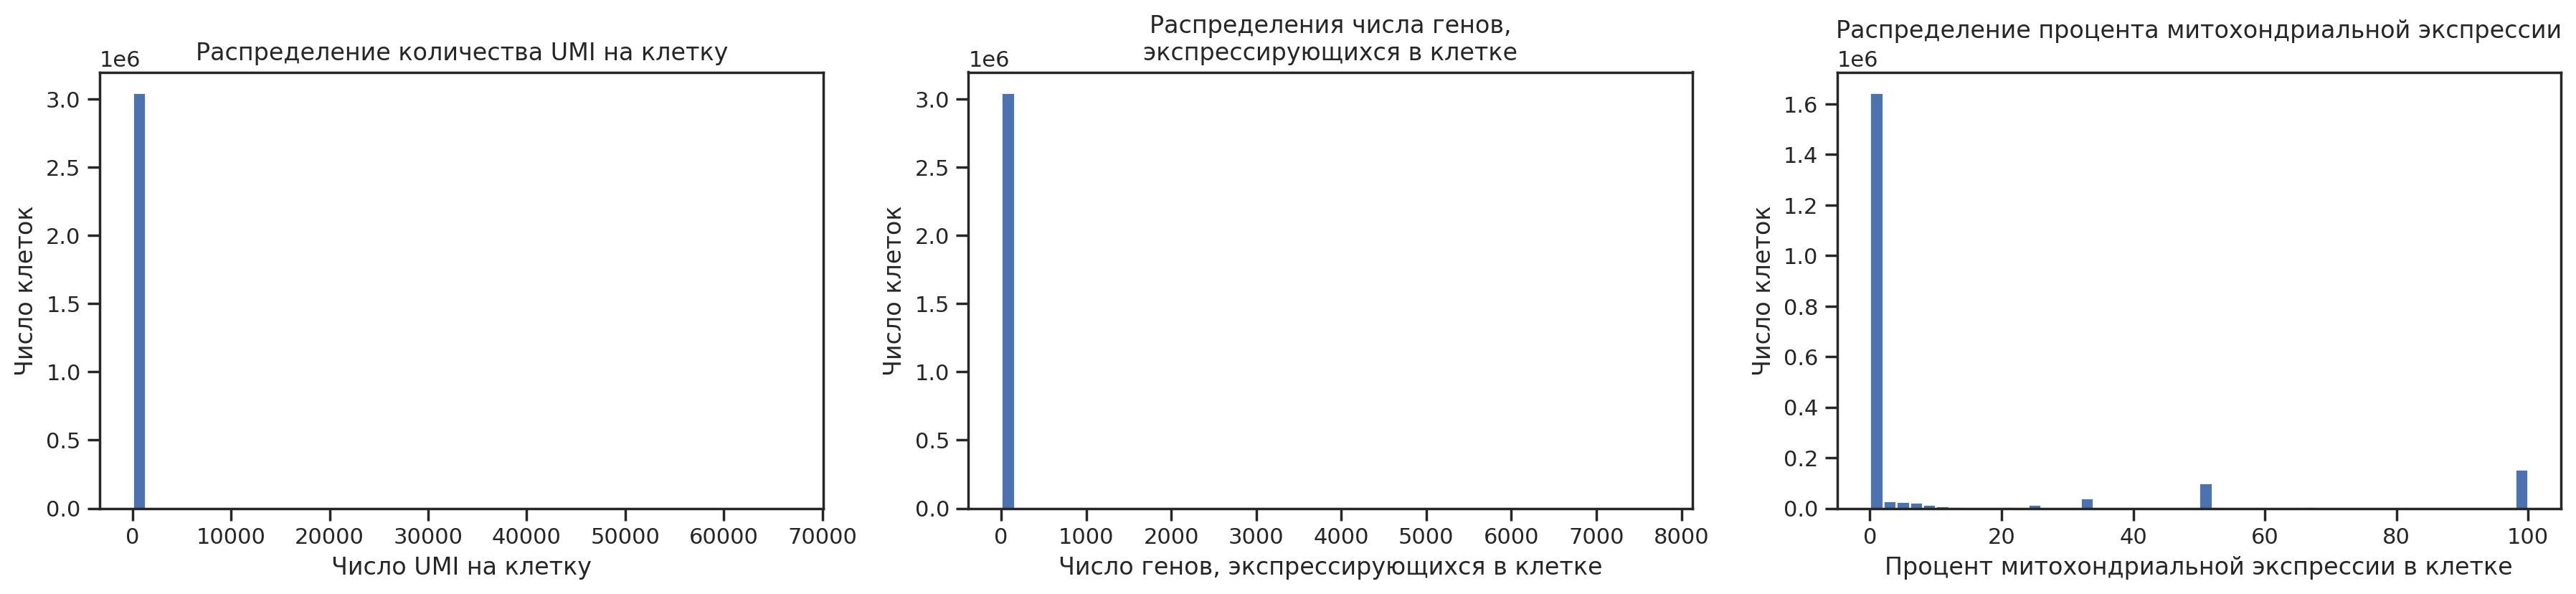

In [ ]:
adata_unfiltered.var["mt"] = adata_unfiltered.var_names.str.startswith("MT-") # В датафрейме с описанием генов делаем отдельный столбик, в котором будет храниться True, если ген митохондриальный
sc.pp.calculate_qc_metrics(adata_unfiltered, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True) # Подсчитываем QC

# Строим графики
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(22, 4)) # Создаём сетку, чтобы отрисовать три графика

# Отрисовываем распределение общего числа UMI
sns.distplot(adata_unfiltered.obs["total_counts"], kde=False, ax=axs[0], hist_kws={"alpha":1})
axs[0].set_xlabel("Число UMI на клетку")
axs[0].set_ylabel("Число клеток")
axs[0].set_title("Распределение количества UMI на клетку")

# Отрисовываем распределение числа генов по клеткам
sns.distplot(adata_unfiltered.obs["n_genes_by_counts"], kde=False, ax=axs[1], hist_kws={"alpha":1})
axs[1].set_xlabel("Число генов, экспрессирующихся в клетке")
axs[1].set_ylabel("Число клеток")
axs[1].set_title("Распределения числа генов,\nэкспрессирующихся в клетке")

# Отрисовываем распределение митохондриальной экспрессии
sns.distplot(adata_unfiltered.obs["pct_counts_mt"], kde=False, ax=axs[2], hist_kws={"alpha":1})
axs[2].set_xlabel("Процент митохондриальной экспрессии в клетке")
axs[2].set_ylabel("Число клеток")
axs[2].set_title("Распределение процента митохондриальной экспрессии")

Подавляющее большинство «клеток» имеют околонулевую экспрессию. фильтруем клетки, оставляем только те, что экспрессируют ≥ 100 UMI на клетку

Text(0.5, 1.0, 'Распределение процента митохондриальной экспрессии')

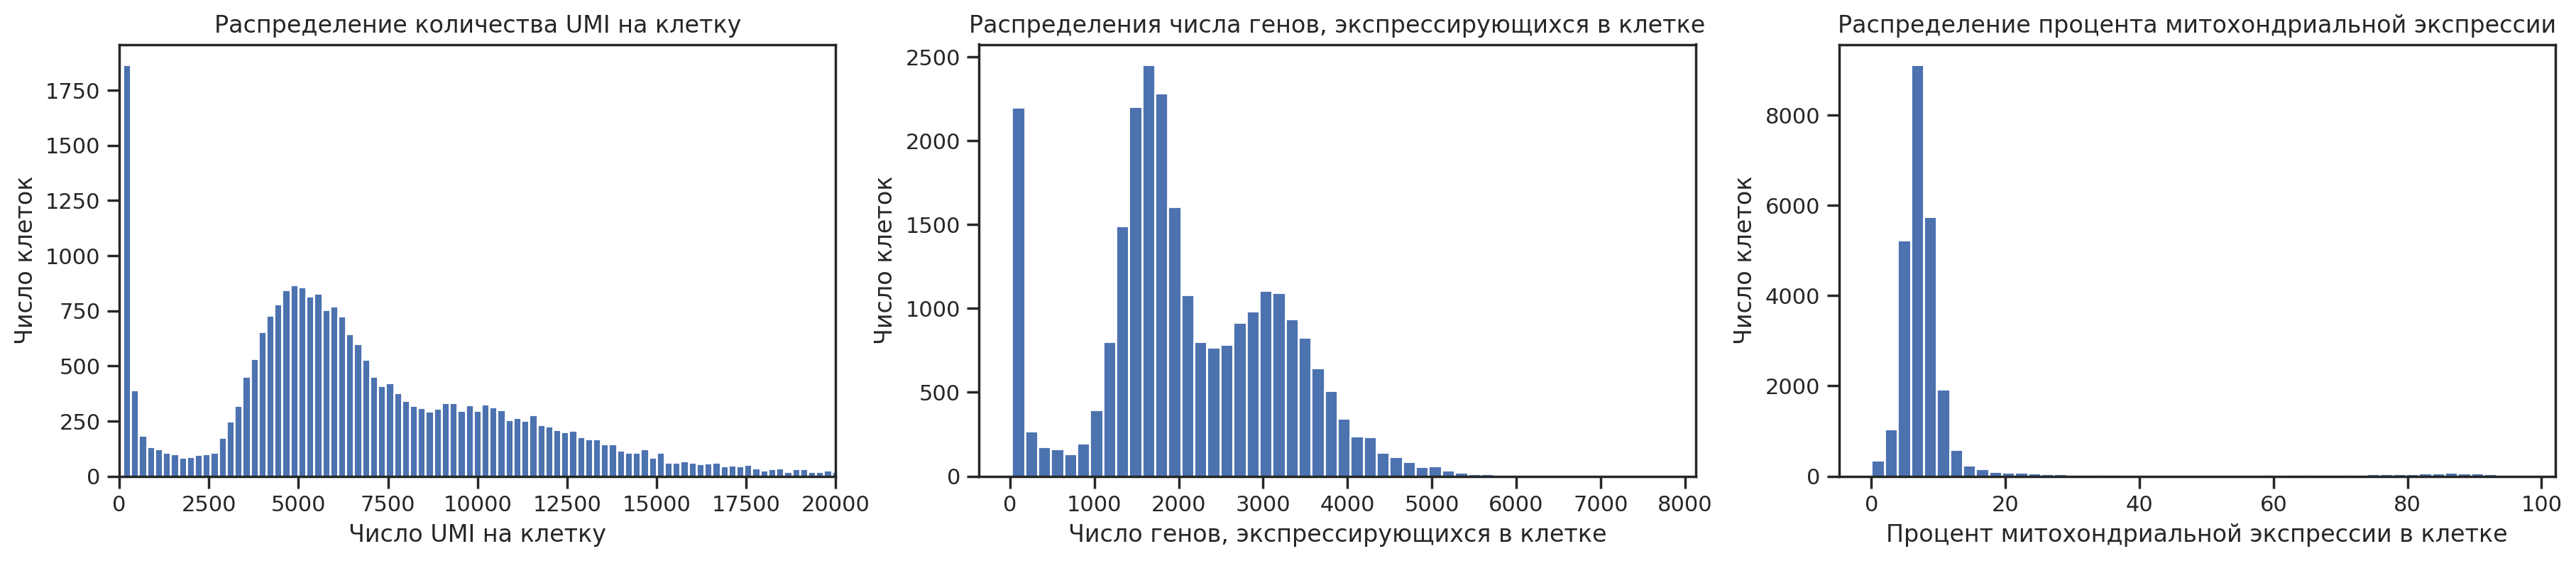

In [ ]:
adata_unfiltered = adata_unfiltered[adata_unfiltered.obs.total_counts >= 100] # Оставляем только те клетки, у которых суммарно ≥ 100 UMI

# Строим графики
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(22, 4))

# Отрисовываем распределение общего числа UMI
sns.distplot(adata_unfiltered.obs["total_counts"], kde=False, ax=axs[0], hist_kws={"alpha":1}, bins=300)
axs[0].set_xlabel("Число UMI на клетку")
axs[0].set_ylabel("Число клеток")
axs[0].set_title("Распределение количества UMI на клетку")
axs[0].set_xlim(0, 20000)

# Отрисовываем распределение числа генов по клеткам
sns.distplot(adata_unfiltered.obs["n_genes_by_counts"], kde=False, ax=axs[1], hist_kws={"alpha":1})
axs[1].set_xlabel("Число генов, экспрессирующихся в клетке")
axs[1].set_ylabel("Число клеток")
axs[1].set_title("Распределения числа генов, экспрессирующихся в клетке")

# Отрисовываем распределение митохондриальной экспрессии
sns.distplot(adata_unfiltered.obs["pct_counts_mt"], kde=False, ax=axs[2], hist_kws={"alpha":1})
axs[2].set_xlabel("Процент митохондриальной экспрессии в клетке")
axs[2].set_ylabel("Число клеток")
axs[2].set_title("Распределение процента митохондриальной экспрессии")

Картина сильно улучшилась. Однако мы до сих пор видим сильный пик в начале. Для того, чтобы от него избавиться, можно просто в ручную посмотреть минимум между двумя пиками (например, по числу генов) — здесь он находится где-то на 500 генах. Также можно избавиться от клеток, у которых больше 25% экспрессии приходится на гены, закодированные в митохондриальной ДНК.

Text(0.5, 1.0, 'Распределение процента митохондриальной экспрессии')

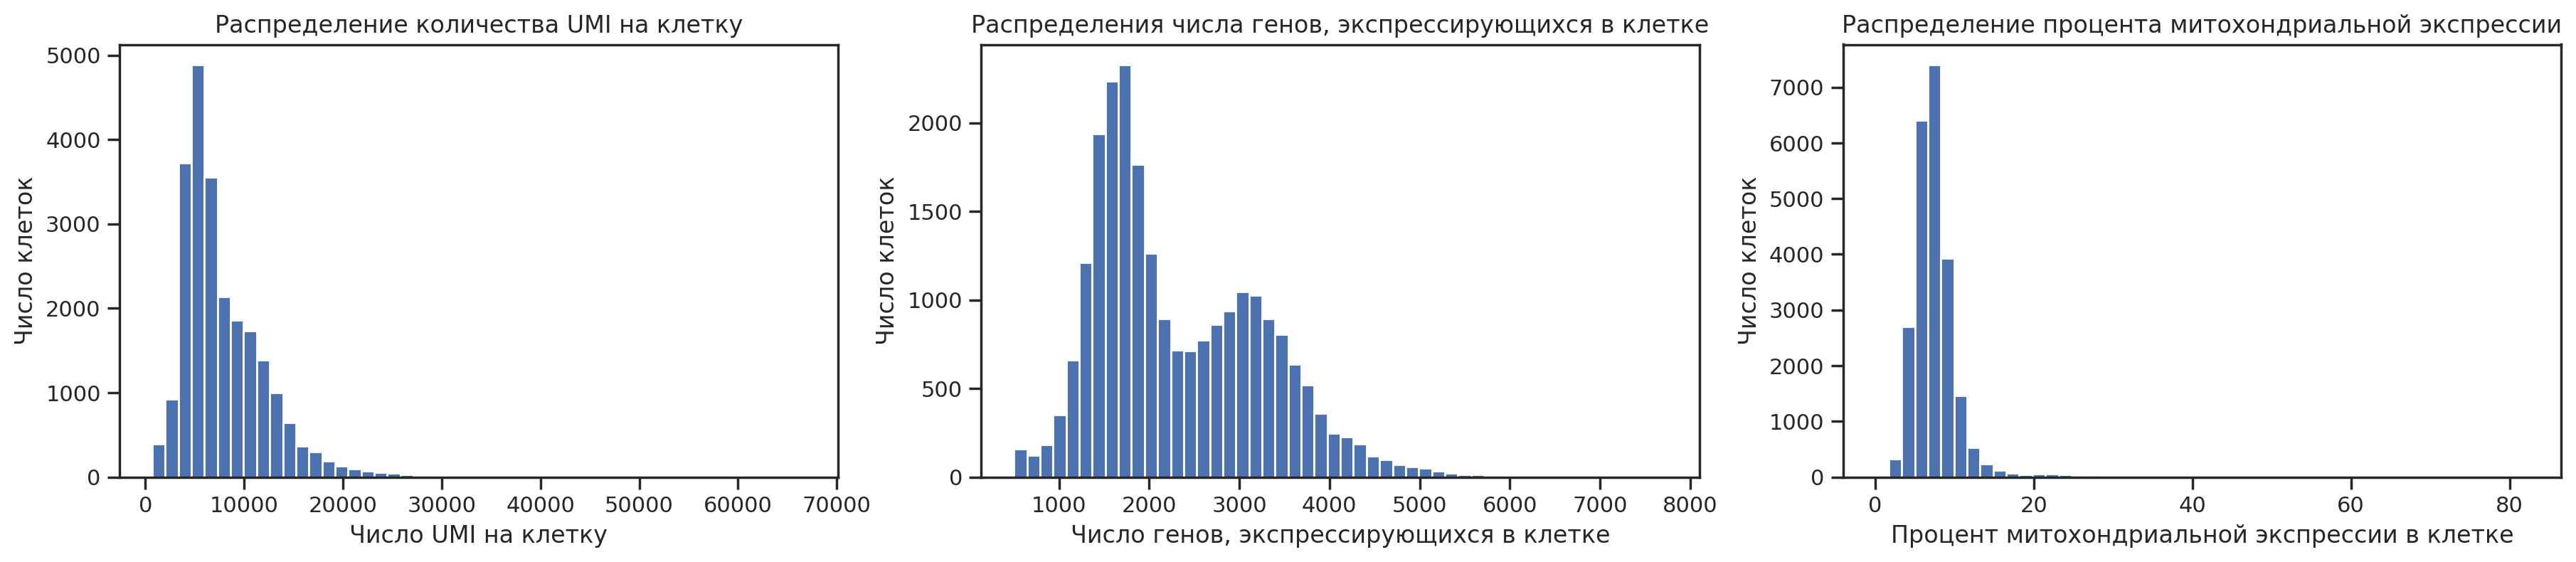

In [ ]:
adata_unfiltered = adata_unfiltered[adata_unfiltered.obs.n_genes_by_counts >= 500] # Оставляем только те клетки, у которых суммарно ≥ 500 генов
adata = adata_unfiltered[adata_unfiltered.obs.pct_counts_mt <= 20]                  # Оставляем только те клетки, у которых меньше 20% митохондриальной экспрессии

# Строим графики
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(22, 4)) 

# Отрисовываем распределение общего числа UMI
sns.distplot(adata_unfiltered.obs["total_counts"], kde=False, ax=axs[0], hist_kws={"alpha":1})
axs[0].set_xlabel("Число UMI на клетку")
axs[0].set_ylabel("Число клеток")
axs[0].set_title("Распределение количества UMI на клетку")

# Отрисовываем распределение числа генов по клеткам
sns.distplot(adata_unfiltered.obs["n_genes_by_counts"], kde=False, ax=axs[1], hist_kws={"alpha":1})
axs[1].set_xlabel("Число генов, экспрессирующихся в клетке")
axs[1].set_ylabel("Число клеток")
axs[1].set_title("Распределения числа генов, экспрессирующихся в клетке")

# Отрисовываем распределение митохондриальной экспрессии
sns.distplot(adata_unfiltered.obs["pct_counts_mt"], kde=False, ax=axs[2], hist_kws={"alpha":1})
axs[2].set_xlabel("Процент митохондриальной экспрессии в клетке")
axs[2].set_ylabel("Число клеток")
axs[2].set_title("Распределение процента митохондриальной экспрессии")

In [ ]:
adata.write_h5ad("10x.h5ad")       #записываем в формат AnnData наши данные, чтобы была возможность их в любой момент прочитать

In [ ]:
adata = sc.read_h5ad("10x.h5ad")

Выявление и устранение дублетов

In [ ]:
sce.pp.scrublet(adata)

Running Scrublet
filtered out 12617 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.19
Detected doublet rate = 5.2%
Estimated detectable doublet fraction = 61.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 8.5%
    Scrublet finished (0:01:07)


In [ ]:
adata.obs.to_csv("adata_obs.tsv", sep="\t")

In [ ]:
obs = pd.read_csv("adata_obs.tsv", sep="\t", index_col=0)
adata.obs = obs

Теперь в adata.obs у нас появилась дополнительная колонка: predicted_doublets

In [ ]:
adata.obs.predicted_doublet

AAACCCAAGAGCAGCT-1    False
AAACCCACAATACCTG-1    False
AAACCCACACAACCGC-1    False
AAACCCACACACAGAG-1     True
AAACCCACAGATCATC-1    False
                      ...  
TTTGTTGGTTCAAGGG-1    False
TTTGTTGTCACCTGGG-1    False
TTTGTTGTCATTGAGC-1    False
TTTGTTGTCCGATGTA-1    False
TTTGTTGTCGTGGCTG-1    False
Name: predicted_doublet, Length: 23232, dtype: bool

Удаляем дублеты

In [ ]:
print(f"Обнаруженное число дублетов: {sum(adata.obs.predicted_doublet)} (из {len(adata)} клеток всего)")
adata = adata[~adata.obs.predicted_doublet]
print(adata)

Обнаруженное число дублетов: 1213 (из 23232 клеток всего)
View of AnnData object with n_obs × n_vars = 22019 × 36601
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'


In [ ]:
print("Суммы UMI на клетку до нормировки:", adata.X.sum(axis=1).T)

sc.pp.normalize_total(adata) # Нормировка
print("Суммы UMI на клетку после нормировки:", adata.X.sum(axis=1).T)

Суммы UMI на клетку до нормировки: [[ 9203.  5705.  8877. ...  6433. 12527.  4419.]]
normalizing counts per cell
    finished (0:00:00)
Суммы UMI на клетку после нормировки: [[6415.     6414.9995 6415.     ... 6414.999  6415.0005 6414.999 ]]


In [ ]:
sc.pp.log1p(adata) # логарифмирование данных

Подготовка к кластеризации и снижению размерности

Выделяем самые высоко вариабельные гены. Это необходимо, чтобы амплифицировать сигнал, которая у нас есть в нашем датасете.

In [ ]:
sc.pp.highly_variable_genes(adata, n_top_genes=3000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Теперь в описании adata.var есть отдельное поле, которое сообщает нам, является ли ген высоко вариабельным.

In [ ]:
adata.var.head() # Выводим верхушку adata.var

,gene_ids,feature_types,genome,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,False,0,0.000000,100.000000,0.0,False,1.000000e-12,NaN,NaN
FAM138A,ENSG00000237613,Gene Expression,GRCh38,False,0,0.000000,100.000000,0.0,False,1.000000e-12,NaN,NaN
OR4F5,ENSG00000186092,Gene Expression,GRCh38,False,0,0.000000,100.000000,0.0,False,1.000000e-12,NaN,NaN
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,False,79,0.000026,99.997426,79.0,False,2.445431e-03,0.211114,0.234543
AL627309.3,ENSG00000239945,Gene Expression,GRCh38,False,12,0.000004,99.999609,12.0,False,4.602156e-04,0.231808,0.292726


In [ ]:
adata.raw = adata #Сохраняем исходные данные в отдельный объект

In [ ]:
adata.write_h5ad("10xafterscrublet.h5ad") 

In [ ]:
adata = sc.read_h5ad("10xafterscrublet.h5ad")

In [ ]:
adata.var_names_make_unique() # Специальная команда, чтобы сделать названия генов уникальными

In [ ]:
adata = adata[:, adata.var.highly_variable] # Оставляем только подмножество генов, которые относятся к HVG
print(adata)

View of AnnData object with n_obs × n_vars = 22019 × 3000
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'scrublet', 'log1p', 'hvg'


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


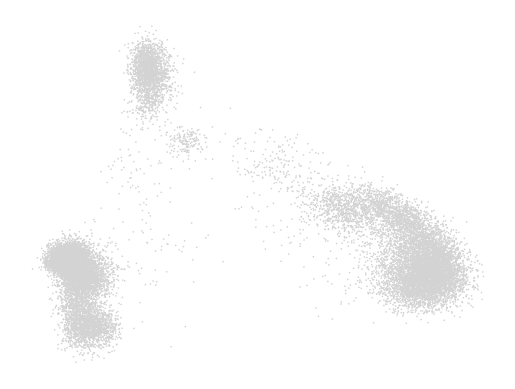

In [ ]:
sc.tl.pca(adata) # Вычисляем PCA
sc.pl.pca(adata, frameon=False) # Отрисовываем PCA

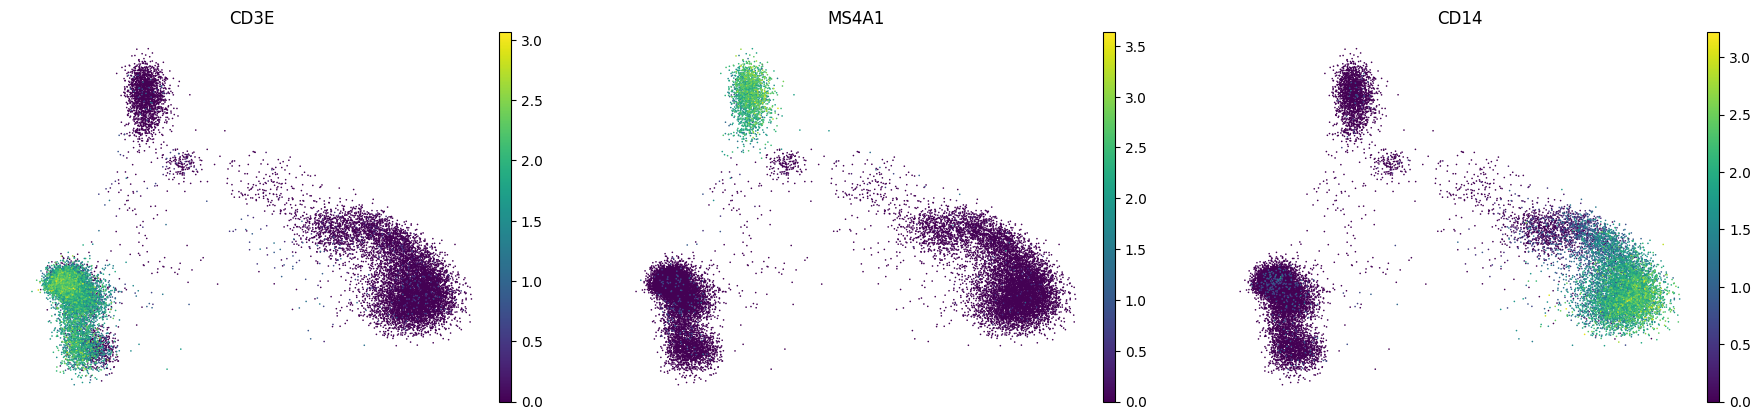

In [ ]:
sc.pl.pca(adata, color=["CD3E", "MS4A1", "CD14"], frameon=False) # Отрисовываем PCA по 3 типам клеток

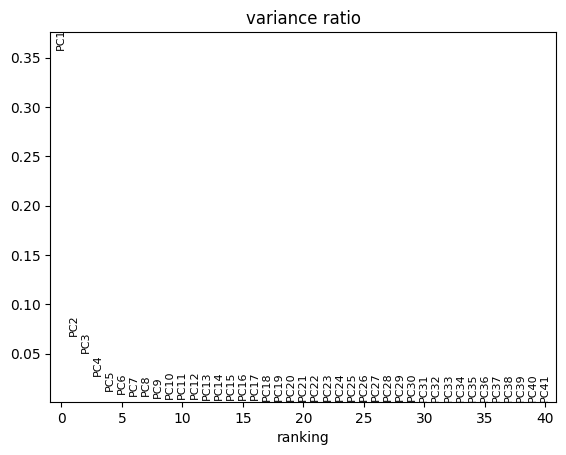

In [ ]:
sc.pl.pca_variance_ratio(adata, log=False, n_pcs=40)

Снижение размерности при помощи UMAP и t-SNE. 

In [ ]:
sc.pp.neighbors(adata, n_pcs=30) # Вычисление графа соседей - это необходимая стадия перед UMAP и t-SNE
sc.tl.umap(adata) # Рассчёт UMAP

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


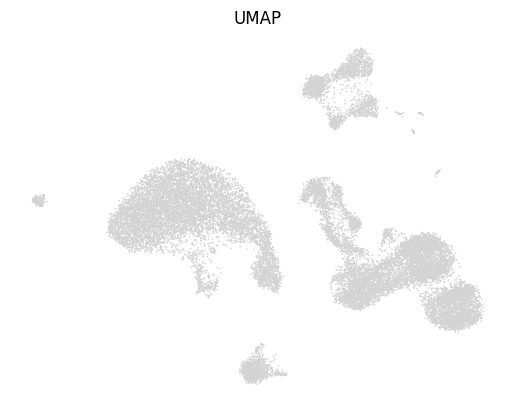

In [ ]:
sc.pl.umap(adata, frameon=False, title="UMAP") # Отрисовываем UMAP

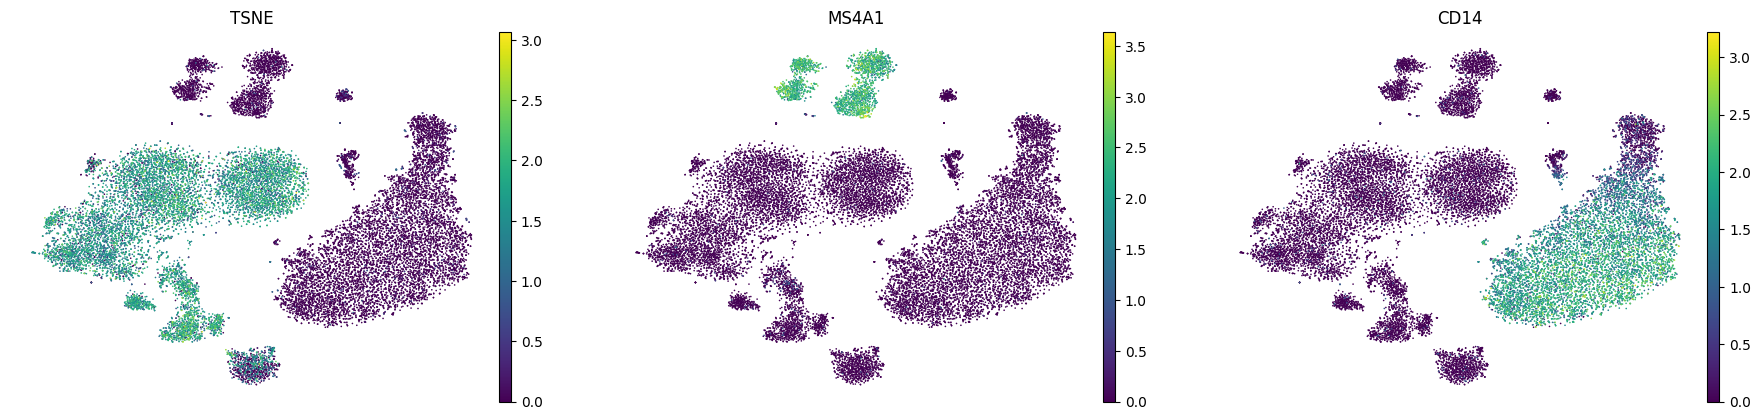

In [ ]:
sc.tl.tsne(adata)
sc.pl.tsne(adata, color=["CD3E", "MS4A1", "CD14"], frameon=False, title="TSNE")

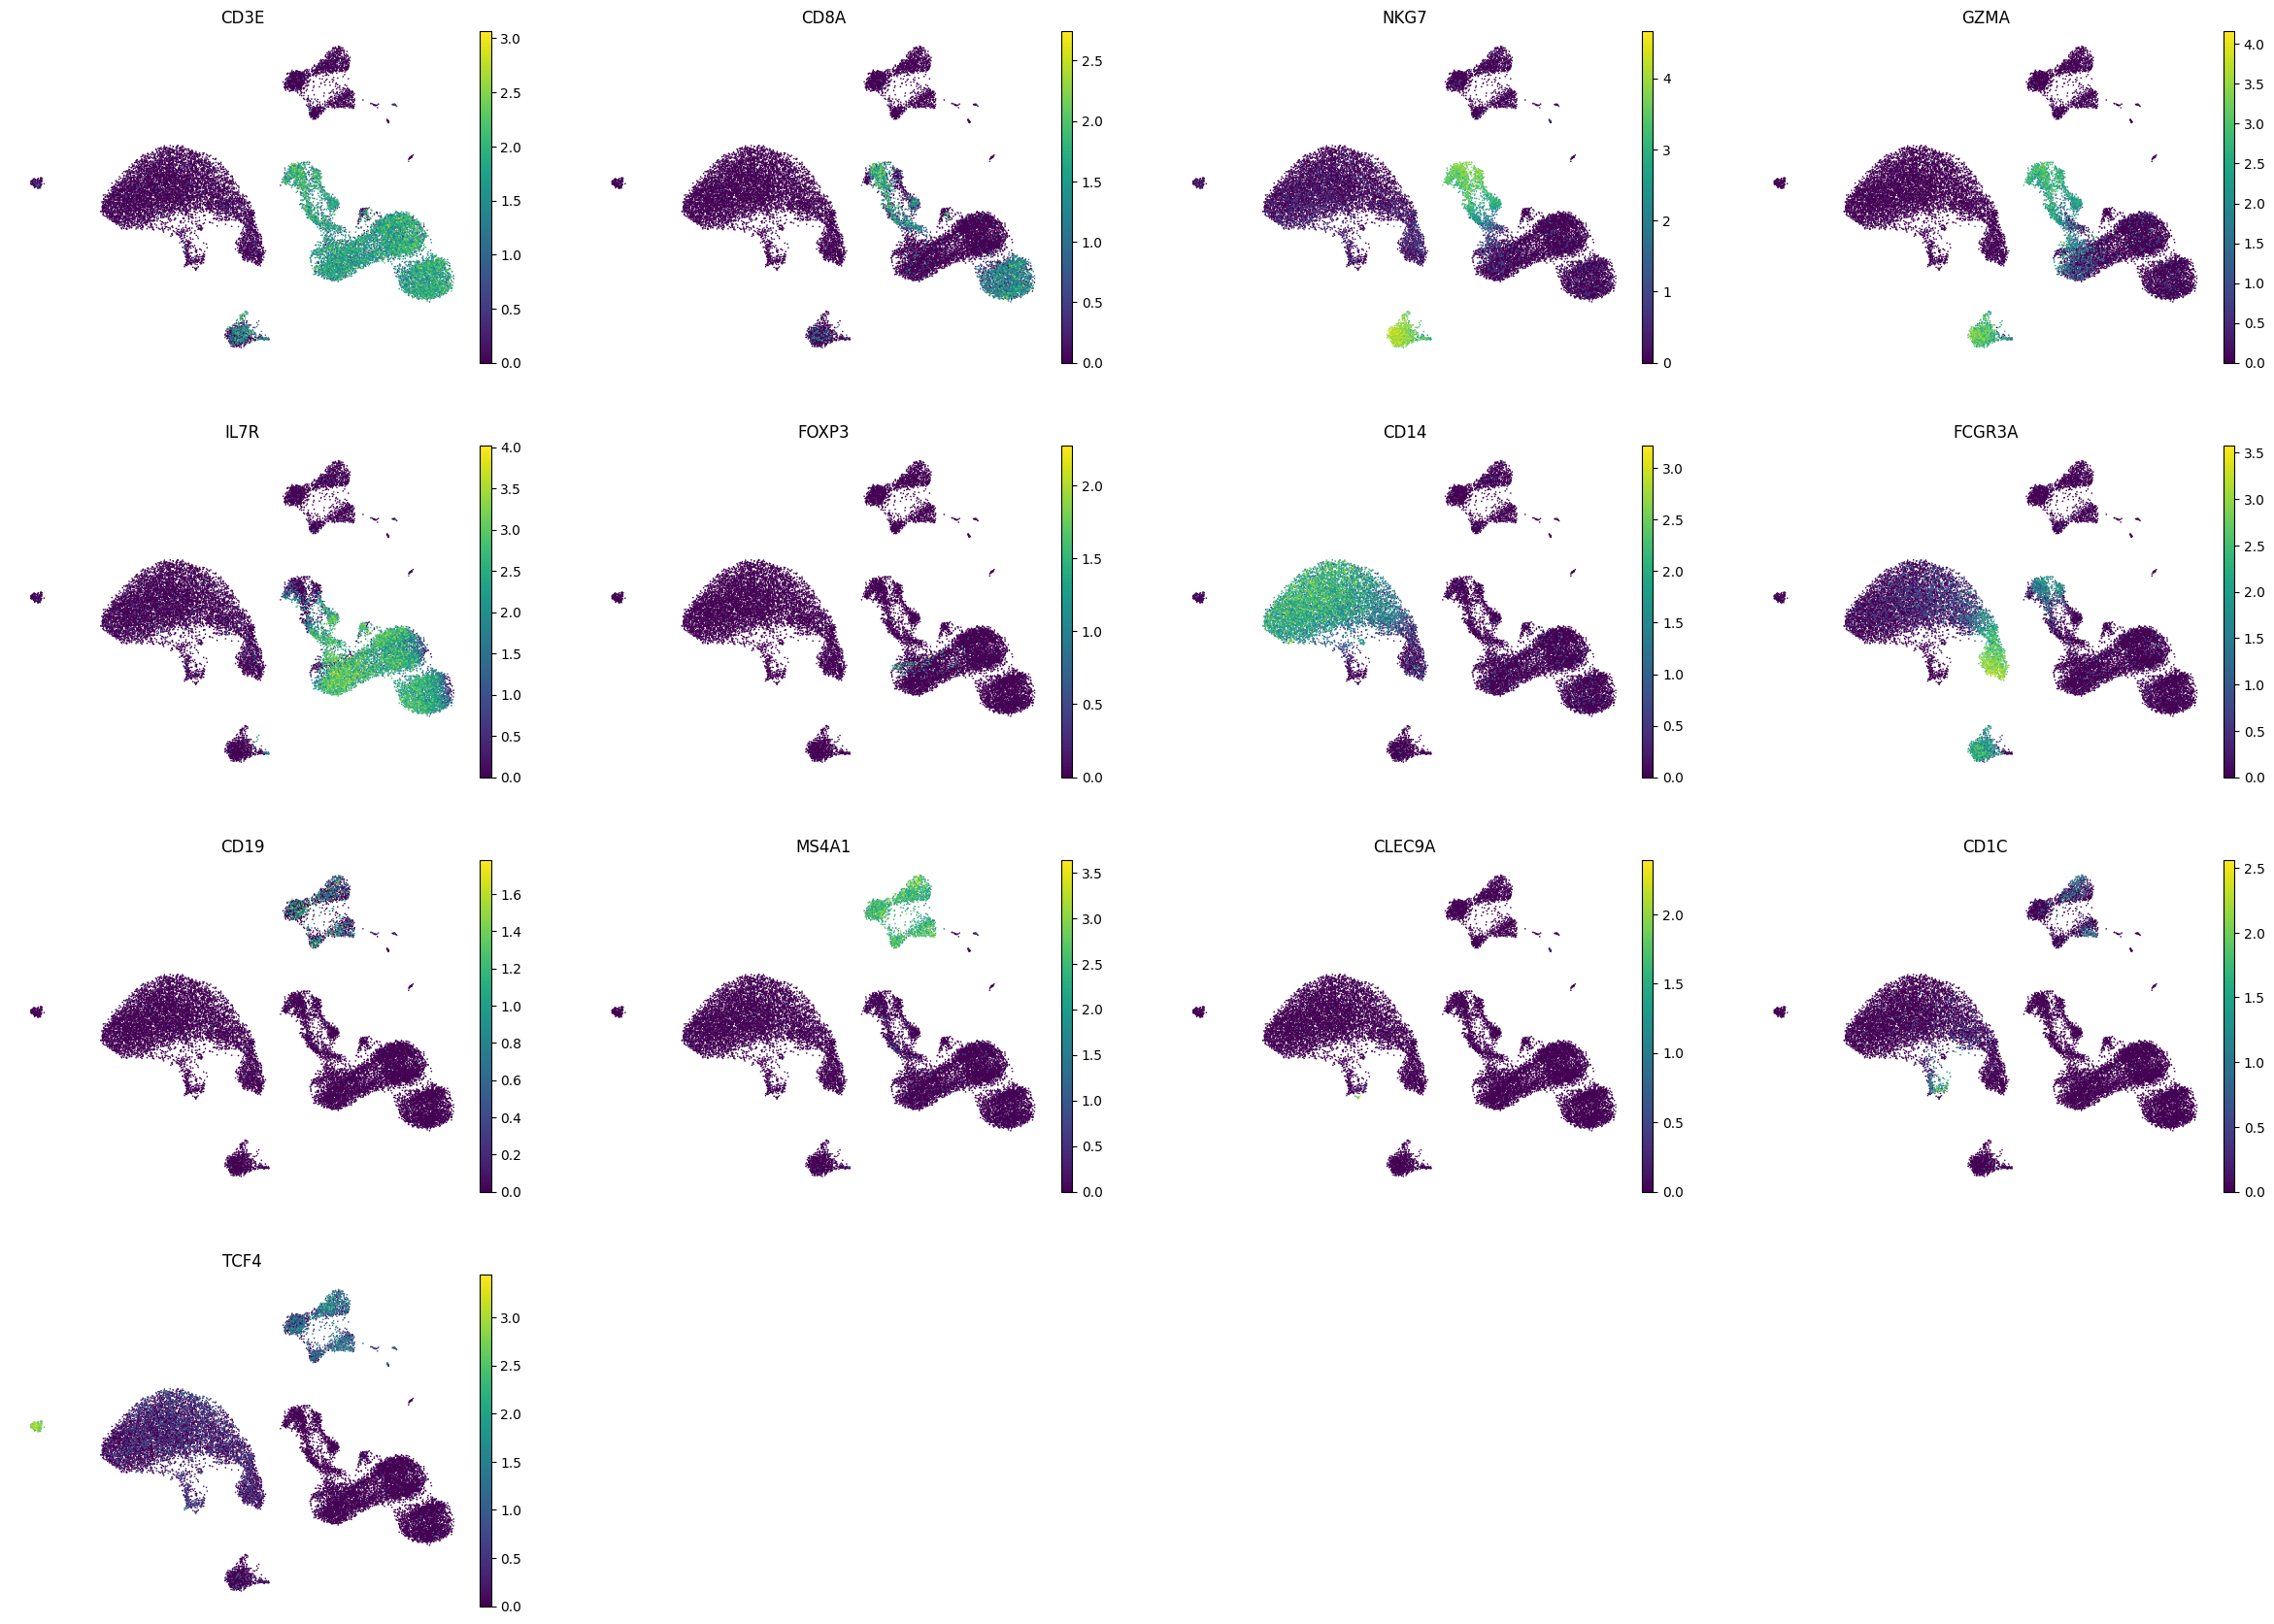

In [ ]:
sc.pl.umap(
    adata,
    color=[
        "CD3E", "CD8A", "NKG7", "GZMA", "IL7R",
        "FOXP3", "CD14", "FCGR3A", "CD19", "MS4A1",
        "CLEC9A", "CD1C", "TCF4",
      ],
    frameon=False
)

In [ ]:
sc.tl.leiden(adata) # Кластеризация алгоритмом Leiden

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


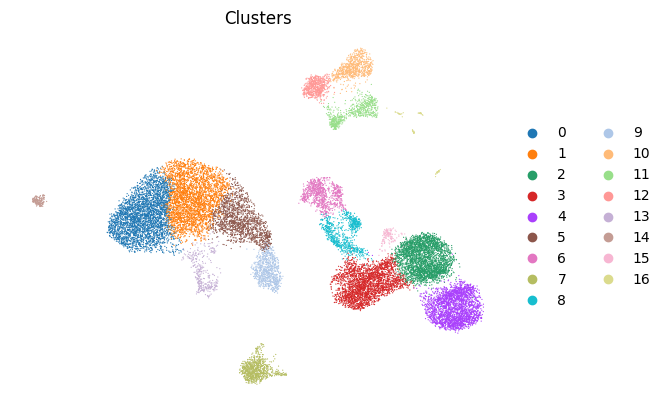

In [ ]:
sc.pl.umap(adata, color="leiden", frameon=False, title="Clusters", s=3) # Отрисовываем UMAP

In [ ]:
#отфильтруем данные 0 кластера для дальнейшего анализа 
DEG = sc.get.rank_genes_groups_df(adata, group="0")
DEG[DEG.logfoldchanges > 2.5]

In [ ]:
# Словарь с маркерными генами
marker_genes_dict = {
    "T-cells" : ["CD3E", "CD4", "CD8A"], 
    "Naive T-cells" : ["CCR7", "SELL", "COTL1"],
    "Memory CD4+ T-cells" : ["ITGB1", "LGALS1"],
    "Cytotoxic T-cells" : ["CCL5", "GZMA"],
    "MAIT T-cells" : ["KLRB1", "SLC4A10"],
    "NK cells" : ["GNLY", "GZMB", "NCAM1"],
    "Progenitor cells" : ["CD34"], 
    "Erythrocytes" : ["HBA1", "HBB"],
    "Monocytes": ["LYZ", "CD14", "FCGR3A"],
    "cDC1" : ["C1orf54", "CLEC9A"],
    "cDC2" : ["ENHO", "CD1C"],
    "pDC" : ["TCF4", "ITM2C", "IRF7"],
    "B-cells" : ["MS4A1"]
} 

In [ ]:
X = adata.to_df(layer=None) #переход от annData в дата фрейм

In [ ]:
X

,HES4,ISG15,TNFRSF18,TNFRSF4,AL391244.2,MMP23B,PLCH2,MEGF6,CCDC27,TNFRSF25,...,PNMA6F,PDZD4,HCFC1-AS1,TKTL1,PLXNA3,MPP1,WASIR1,TTTY10,AC011043.1,AC233755.1
AAACCCAAGAGCAGCT-1,0.0,1.128548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
AAACCCACAATACCTG-1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.178318,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
AAACCCACACAACCGC-1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.153089,0.0,0.0,0.0,0.0
AAACCCACAGATCATC-1,0.0,0.415752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
AAACCCACAGCGCGTT-1,0.0,1.482164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.112343,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTTCAAGGG-1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.227463,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
TTTGTTGTCACCTGGG-1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
TTTGTTGTCATTGAGC-1,0.0,1.096745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
TTTGTTGTCCGATGTA-1,0.0,0.413495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.413495,0.0,0.0,0.0,0.0


Кластеризация методом K-means

In [ ]:
from sklearn.cluster import KMeans

Text(0, 0.5, 'Инерция кластеризации')

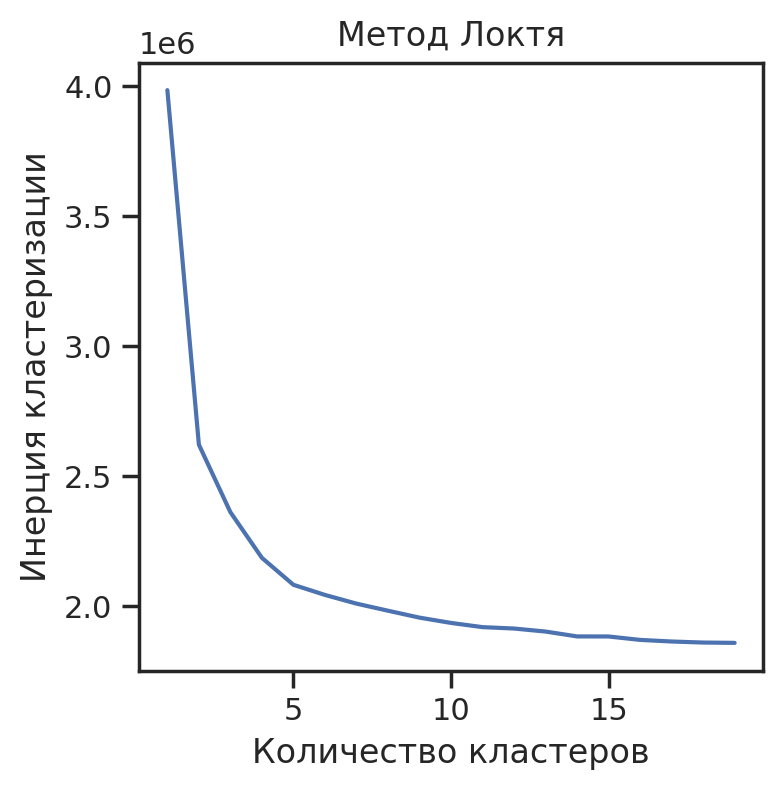

In [ ]:
#определение количества кластеров для обучения k-means
n_inertia=[]
for i in range(1, 20):
  model = KMeans(n_clusters=i).fit(X)
  n_inertia.append(model.inertia_)

fig, ax = plt.subplots()
sns.lineplot(x=np.arange(1, 20), y=n_inertia, ax=ax)
ax.set_title('Метод Локтя')
ax.set_xlabel('Количество кластеров')
ax.set_ylabel('Инерция кластеризации')

In [ ]:
model = KMeans(n_clusters=17).fit(X)

# Предсказание на всем наборе данных
all_predictions = model.predict(X)

# Выводим предсказания
print(all_predictions)

[ 5  1  7 ... 10  7  4]


computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:10)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:19)


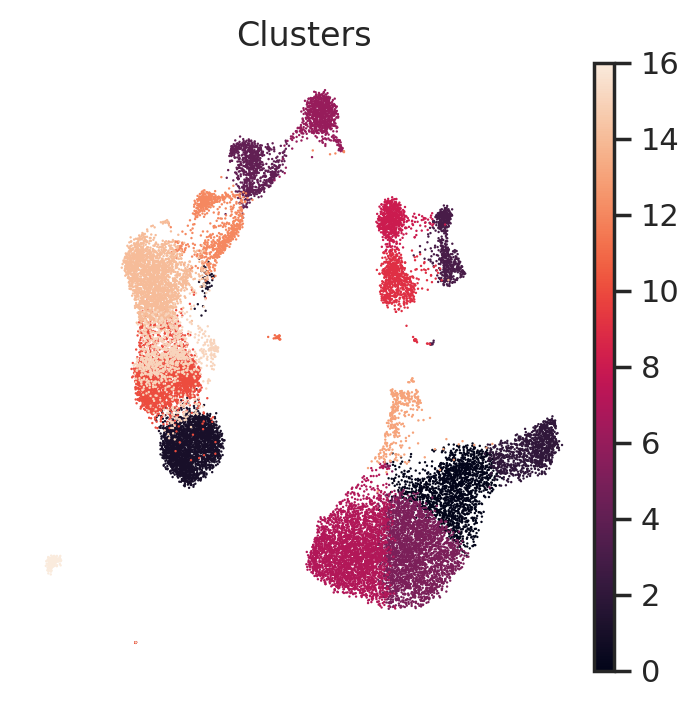

In [ ]:
adata1 = sc.AnnData(X)
adata1.obs['cluster'] = all_predictions
sc.pp.neighbors(adata1) 
sc.tl.umap(adata1, n_components=2)
sc.pl.umap(adata1, color=['cluster'], frameon=False, title="Clusters", s=3) #отрисовываем UMAP

Кластеризация методом случайного леса

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# разбиваем данные на обучающую и тестовую выборки
y = all_predictions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# создаем и обучаем модель на обучающей выборке
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
clf.fit(X_train, y_train)

# оцениваем качество модели на тестовой выборке
accuracy = clf.score(X_test, y_test)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.82


Построение нейронной сети

In [ ]:
#Подготовка дата фрейма
X['cluster'] = all_predictions
X1 = X.copy()
y = X['cluster']
del X['cluster']

In [ ]:
#нейронная сеть
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
n_classes = 17
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)
n_genes = X.shape[1]

#Структура нейронной сети
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(n_genes, )),
    tf.keras.layers.Dense(n_classes, activation='softmax') # n_clusters - количество кластеров для предсказания
])

# Компиляция модели
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# обучаем модель
history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.1)

#оцениваем обученную модель
model.evaluate(X_test, y_test, verbose=1)

Epoch 1/20
109/109 [==============================] - 3s 9ms/step - loss: 0.9020 - accuracy: 0.7586 - val_loss: 0.3629 - val_accuracy: 0.9125
Epoch 2/20
109/109 [==============================] - 1s 6ms/step - loss: 0.2559 - accuracy: 0.9352 - val_loss: 0.2282 - val_accuracy: 0.9287
Epoch 3/20
109/109 [==============================] - 1s 6ms/step - loss: 0.1691 - accuracy: 0.9565 - val_loss: 0.1807 - val_accuracy: 0.9436
Epoch 4/20
109/109 [==============================] - 1s 6ms/step - loss: 0.1247 - accuracy: 0.9715 - val_loss: 0.1653 - val_accuracy: 0.9377
Epoch 5/20
109/109 [==============================] - 1s 7ms/step - loss: 0.0971 - accuracy: 0.9810 - val_loss: 0.1507 - val_accuracy: 0.9468
Epoch 6/20
109/109 [==============================] - 1s 7ms/step - loss: 0.0789 - accuracy: 0.9861 - val_loss: 0.1451 - val_accuracy: 0.9436
Epoch 7/20
109/109 [==============================] - 1s 7ms/step - loss: 0.0638 - accuracy: 0.9901 - val_loss: 0.1376 - val_accuracy: 0.9429
Epoch 

[0.13979719579219818, 0.9479261040687561]

In [ ]:
model.summary() # архитектура модели

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                96032     
                                                                 
 dense_7 (Dense)             (None, 17)                561       
                                                                 
Total params: 96,593
Trainable params: 96,593
Non-trainable params: 0
_________________________________________________________________


<Axes: >

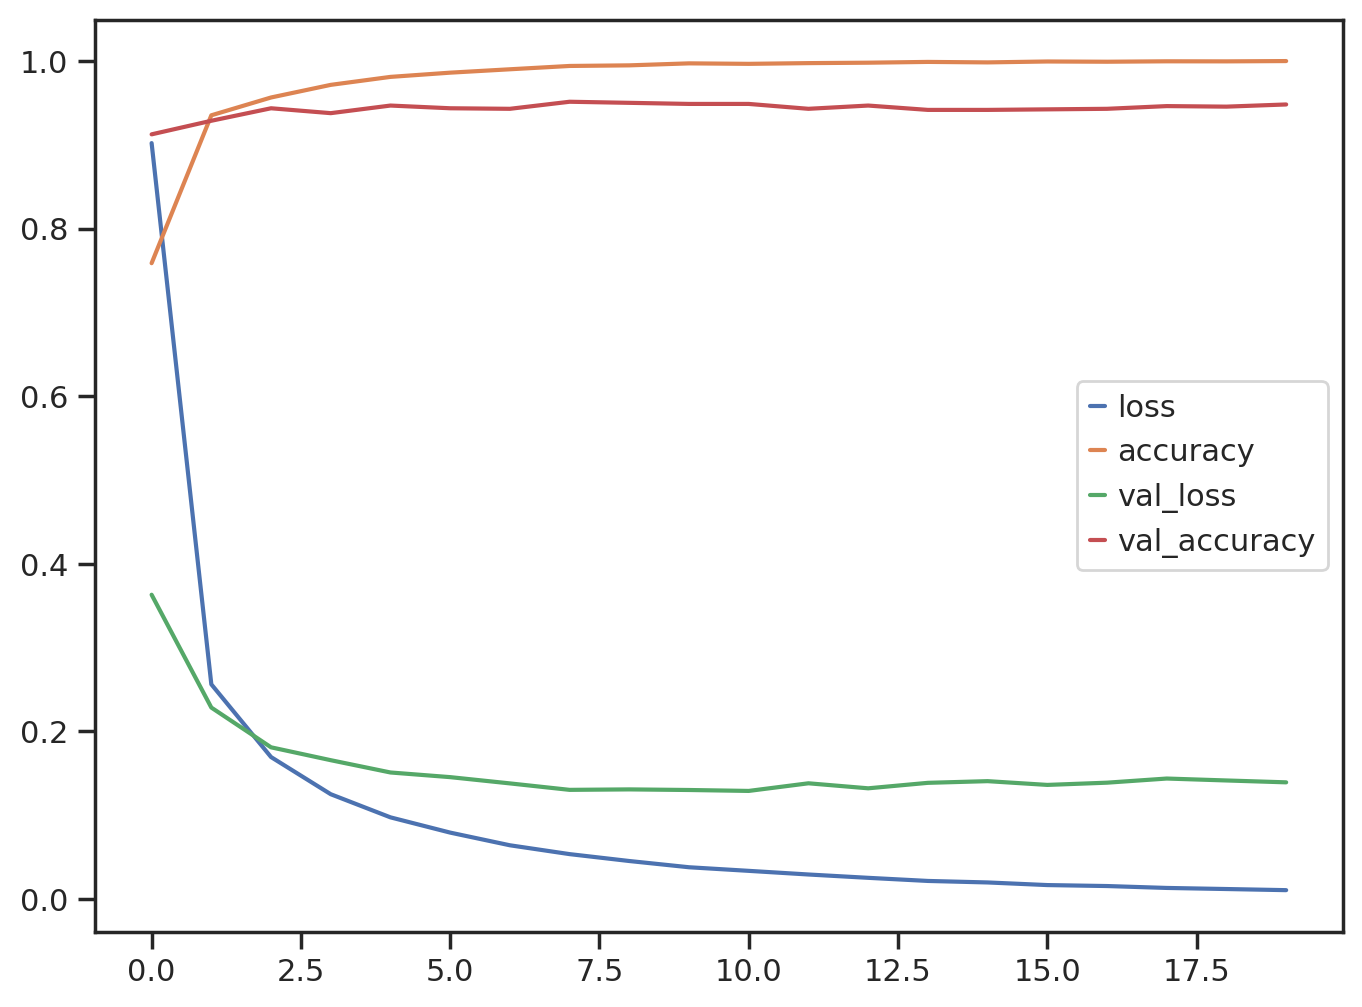

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,6)) # метрики и функции потерь